In [120]:
from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import matplotlib.pyplot as plt
import random
from datetime import datetime, timedelta

## Group Assignment
### Team Number: 05
### Team Member Names: James Begin, Jonathan Wen, Emily Qi
### Team Strategy Chosen: Market Meet

Disclose any use of AI for this assignment below (detail where and how you used it).  Please see the course outline for acceptable uses of AI.


# Introduction 
The goal of the market "meet" portfolio is to match the returns of the average of the TSX60 and S&P500 indices as closely as possibly. To do this, we look at various indicators that can provide insight into a stock's ability to match market returns. Below are the factors we plan to take into account while constructing our portfolio:  
- Volume
- Price
- Market Cap
- Beta Score
- EJJ (Emily, Jonathan, James) Score (pronounced like "edge")
- Earnings and Dividend Dates  

## Filtering
First, we ignore any delisted stocks, stocks lacking information, or non-US and Canadian Stocks, then filter by average monthly volume, minimum price, and market cap:
  



In [121]:
tickers = pd.read_csv('Tickers.csv')
#remove any whitespace from each ticker
tickerlist = [tickers.columns[0].strip()]
tickerlist += [i.strip() for i in tickers.iloc[:,0]]
#remove duplicates from the list
tickerlist = list(dict.fromkeys(tickerlist))

#for our analysis, use the year of 2024
startdate = '2024-01-01'
enddate = datetime.now().strftime('%Y-%m-%d')

stockdata = yf.download(tickerlist, start=startdate, end=enddate)
#remove any delisted tickers
delisted = list(yf.shared._ERRORS.keys())
for i in delisted:
    tickerlist.remove(i)
    
exchangelist = ['NMS', 'NYQ', 'TOR']
minprice = 5
minvolume = 100000
mincap = 1000000000

#remove any tickers that dont satisfy our filter requirements
for ticker in tickerlist:
    t = yf.Ticker(ticker)
    hist = t.history(start=startdate, end=enddate, period='1mo')
    inf = t.fast_info
    if ((t.get_history_metadata())['exchangeName'] not in exchangelist
            or hist['Volume'].mean() < minvolume 
            or hist['Close'].mean() < minprice
            or inf['market_cap'] < mincap):
        tickerlist.remove(ticker)    

FileNotFoundError: [Errno 2] No such file or directory: 'Tickers.csv'

## Earnings Dates and Dividends
The period surrounding Earnings Dates, and Dividend Dates typically bring about higher volatility as investors and speculators buy and sell, hoping to take advantage of upcoming news and guidance. Below we illustrate some of the effects of Earnings/Corporate Announcements on volatility.


<BarContainer object of 2 artists>

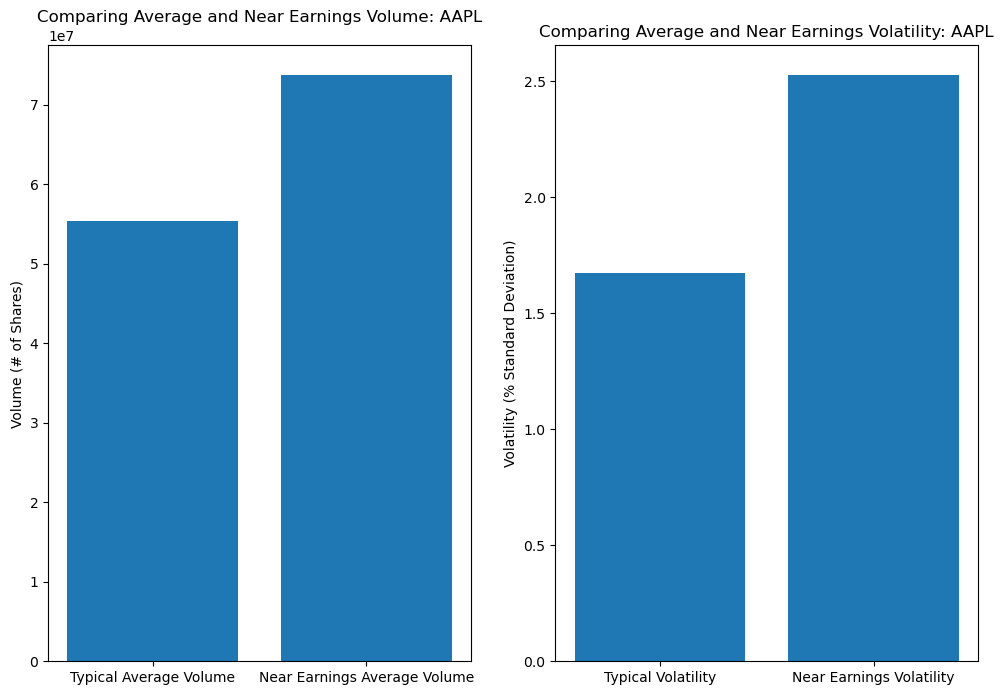

In [ ]:
start1='2024-07-10'
end1='2024-07-24'
start2='2024-04-24'
end2='2024-05-06'
voldata = stockdata.loc[:, 'Volume']
plot1 = voldata.loc[start1:end1, 'AAPL'].mean()
plot2 = voldata.loc[start2:end2, 'AAPL'].mean()
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(12, 8)
ax1.set_title("Comparing Average and Near Earnings Volume: AAPL")
ax1.set_ylabel('Volume (# of Shares)')
ax1.bar(['Typical Average Volume', 'Near Earnings Average Volume'], [plot1, plot2])

plot3 = stockdata.loc[:, 'Adj Close'].loc[start1:end1, 'AAPL'].pct_change().std() * 100
plot4 = stockdata.loc[:, 'Adj Close'].loc[start2:end2, 'AAPL'].pct_change().std() * 100
ax2.set_title("Comparing Average and Near Earnings Volatility: AAPL")
ax2.set_ylabel("Volatility (% Standard Deviation)")
ax2.bar(['Typical Volatility', 'Near Earnings Volatility'], [plot3, plot4])

Notice the significant increase in both volume and volatility when AAPL is near earnings. This is what we want to avoid.

Considering that we want to minimize volatility in order to meet the market, we filter out any stocks that have upcoming earnings or dividend dates:

In [ ]:
#fetch the current and cutoff dates
currdate = (datetime.now()).date()
cutoff = (currdate + timedelta(days=14))

for ticker in tickerlist:
    #fetch the relevant dates
    cal = yf.Ticker(ticker).calendar
    #ensure that the yfinance has the dates we want
    div = (cal['Ex-Dividend Date'] if 'Ex-Dividend Date' in cal.keys() else cutoff)
    earnings = (cal['Earnings Date'][1] if len(cal['Earnings Date']) > 1 else cal['Earnings Date'][0])
    #check if there are events in the near future
    if ((earnings > currdate) and (cutoff > earnings)) or ((div > currdate) and (cutoff > div)):
        tickerlist.remove(ticker)
        

## Beta Score
Our initial plan was to sort stocks by value of beta, with greater preference given to stocks with betas closer to 1.0. A beta of 1.0 indicates that a stock follows the market's returns exactly. This made intuitive sense to us as beta is a measure of volatility of a security or portfolio compared to the market. Thus, since our goal is to meet the market, stocks with betas of 1.0 would help us to achieve portfolio values closest to the market indices. 

We will outline why this scoring method is not ideal by showing the results we obtained when only looking at betas.

To begin, we realized that yfinance provides a beta value comparing each stock the S&P500 index. However, as we want to match the average of both the TSX60 and the S&P500, we will calculate beta when compared to the TSX60. Then, we can take the average of the two betas in order to accurately represent the volatility compared to the index used in this assignment.

We can calculate beta using the formula (Covariance(Individual Returns, Market Returns)) / (Variance(Market Returns))

In [ ]:
tsxpriceBeta = yf.download('XIU.TO', start=startdate, end=enddate)['Adj Close']
sppriceBeta = yf.download('SPY', start=startdate, end=enddate)['Adj Close']
beta_dict = {}
closedataBeta = stockdata.loc[:, 'Adj Close']

tsxpriceBeta.index = tsxpriceBeta.index.tz_localize(None) 
sppriceBeta.index = sppriceBeta.index.tz_localize(None) 
closedataBeta.index = closedataBeta.index.tz_localize(None)
#pre calculate variance of the TSX index to avoid looped computation
tsxpctBeta = tsxpriceBeta.pct_change(fill_method=None)
tsxvarBeta = tsxpctBeta.var()

#calculate beta for each stock
for ticker in tickerlist:
    #prevent any mismatched indexes
    commonBeta = closedataBeta[ticker].index.intersection(tsxpriceBeta.index)
    closepctBeta = closedataBeta.loc[commonBeta, ticker].pct_change(fill_method=None)
    #calculate beta with respect to TSX
    beta1 = closepctBeta.cov(tsxpctBeta) / tsxvarBeta
    #fetch beta with respect to SP500
    beta2 = yf.Ticker(ticker).info.get('beta') 
    beta_dict[ticker] = abs(1.0 - (beta1 + (beta2 if beta2 else beta1)) / 2)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Now that we have the betas of each stock calculated, we can sort them in order of closeness to 1.0 as well as graph some of them to see how closely they match market indices.

The stocks sorted by closeness to 1.0 are: 
BK 0.014538835838377118
ACN 0.022305907534460045
AIG 0.026128478055478244
UPS 0.030111455012206134
UNP 0.07579473262740366
AAPL 0.09971182875964746
TXN 0.12797801636928807
RY.TO 0.1429459873101766
USB 0.16347368175032506
AMZN 0.20876408348627895
AXP 0.21690365245931642
CAT 0.28640670284818426
BA 0.3274794180862839
PFE 0.36623649681570913
PYPL 0.39087268154432153
C 0.4303874772291283
T.TO 0.4717616044301761
ABT 0.49893869567890237
LLY 0.5501557236165218
UNH 0.552973897907621
ABBV 0.5729066415813475
BIIB 0.5882308898202137
PM 0.620370257304492
BMY 0.6204515148331655
MO 0.6369211146904822
MRK 0.6910049267260383
CL 0.7974887334651071
PG 0.7981372975767136
SHOP.TO 1.2929936911729687


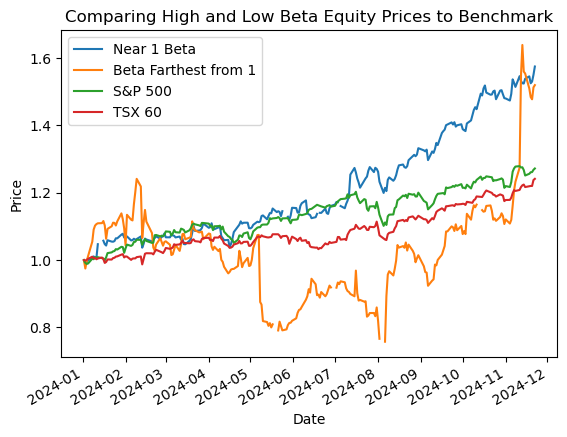

In [ ]:
#sort betas in order of closeness to 1.0
beta_sorted = []
print('The stocks sorted by closeness to 1.0 are: ')
for t in sorted(beta_dict, key=beta_dict.get, reverse=False):
    beta_sorted.append(t) 
    print(t, beta_dict[t])

#display graph showing returns of highest and lowest scores compared to benchmark
fig, ax = plt.subplots()
ax.set_title("Comparing High and Low Beta Equity Prices to Benchmark")
ax.set_xlabel("Date")
ax.set_ylabel("Price")

ax.plot(closedataBeta[beta_sorted[0]] / (closedataBeta[beta_sorted[0]]).values[0], label='Near 1 Beta')
ax.plot(closedataBeta[beta_sorted[-1]] / (closedataBeta[beta_sorted[-1]]).values[0], label='Beta Farthest from 1')
ax.plot(sppriceBeta / sppriceBeta.values[0], label='S&P 500')
ax.plot(tsxpriceBeta / tsxpriceBeta.values[0], label='TSX 60')
ax.legend(loc='best')
fig.autofmt_xdate()

plt.show()

As you can see, the graph produced is not ideal. Although the returns of the stock with beta closest to 1 seem to match the market much better than those of the stock with beta farthest from 1, there is still a lot of room for improvement. Thus, we found it necessary to create our own scoring system—dubbed EJJ Score—to make up for what beta lacks. Rationale for this decision is outlined below.

## EJJ Score
The weakness in our previous strategy lies in the fact that beta is only a measure of how sensitive a stock's returns are compared to the market. We could have a stock with beta close to 1.0, but with a low correlation, which is not what we are after. Considering we want to match the market's returns exactly, we use correlation to identify the strength of a relationship with an index.  
  
We calculate the rolling correlation with each stock to the market average, as this ensures we capture how the correlation might have changed over past (especially in recent months). Then, we find both the average correlation and standard deviation of the correlation. Using this, we identify how often the stock is highly correlated (over a certain correlation threshold). The result of this metric is a percentage.  
  
Then, we calculate how stable the correlation is for each stock. This is done by dividing the average correlation by the standard deviation of the correlation. This ensures that we also take into account, not only high correlation, but high correlation that doesn't change often.  
  
To calculate the final score, we find the reciprocal of the distance of each beta to 1.0 (this ensures that bigger values are always better) and multiply it by the percent of time the stock is highly correlated. and by how stable the correlation is.  

  
We can calculate beta using the same formula as listed above: (Covariance(Individual Returns, Market Returns)) / (Variance(Market Returns))

In [ ]:
indices = pd.DataFrame()
indices['tsxprice'] = yf.download('XIU.TO', start=startdate, end=enddate)['Adj Close']
indices['spprice'] = yf.download('SPY', start=startdate, end=enddate)['Adj Close']

closedata = stockdata.loc[:, 'Adj Close']

indices.index = indices.index.tz_localize(None) 
closedata.index = closedata.index.tz_localize(None)

tsxpct = indices['tsxprice'].pct_change(fill_method=None)
sppct = indices['spprice'].pct_change(fill_method=None)
avgpct = (tsxpct + sppct) / 2
tsxvar = tsxpct.var()
spvar = sppct.var()
avgvar = (tsxvar + spvar) / 2
scores = {}

#calculate score for each stock
for ticker in tickerlist:
    #prevent any mismatched indexes
    common = closedata[ticker].index.intersection(indices.index)
    
    closepct = closedata.loc[common, ticker].pct_change(fill_method=None)
    
    #calculate beta with respect to TSX and S&P Average
    beta = closepct.cov(sppct) / spvar
    
    #print(beta)
    #calculate weekly rolling correlation (7 day window)
    rolling_correlation = closepct.rolling(window=14).corr(sppct)
    correlation_std = rolling_correlation.std()
    correlation_mean = rolling_correlation.mean()
    #find how often each stock is strongly correlated
    correlation_pct = (rolling_correlation > 0.5).mean()
    #find how consistent the correlation is
    consistency = correlation_mean / (correlation_std if correlation_std != 0 else 0.0001)
    #calculate score
    
    #print(ticker, 1 / (1 + abs(beta-1.0)), correlation_mean, correlation_pct, consistency)
    score = correlation_pct * (1 / (1 + abs(beta - 1.0))) * consistency
    
    scores[ticker] = abs(score)



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


The highest score stocks are: 
AMZN 2.8036306582472332
AAPL 1.6997550742143628
CAT 1.5345684389949823
C 1.4553651900560556
TXN 1.1451607128755197
AXP 1.0327676994230963
USB 0.8202241908751091
SHOP.TO 0.5533547307151376
ACN 0.5187273831895585
RY.TO 0.49190989181055567
AIG 0.47095858258738715
BK 0.4431407551177247
PYPL 0.398904052921567
UNP 0.3539604666234708
UPS 0.21520893764724597
LLY 0.20767421197453698
BIIB 0.18992280589770177
BA 0.1276564474962377
PFE 0.04447704186369553
MRK 0.03134235717672369
ABBV 0.029354495254346143
ABT 0.02818471143985394
T.TO 0.015891683065774702
UNH 0.013300197423049241
PM 0.01100869563894838
MO 0.007199468175095411
BMY 0.005133536190028528
CL 0.0028592714623389176
PG 6.820540990995428e-05


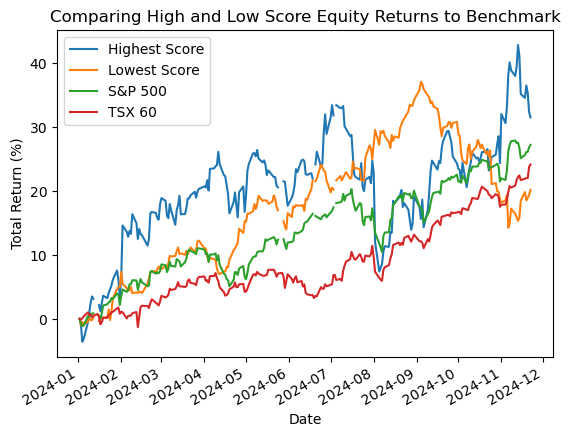

In [ ]:
#sort stocks in order of EJJ score
scores_sorted = []
print('The highest score stocks are: ')
for t in sorted(scores, key=scores.get, reverse=True):
    scores_sorted.append(t)
    print(t, scores[t])

#graph highest and lowest-scored stocks' returns compared to benchmark
fig, ax = plt.subplots()
ax.set_title("Comparing High and Low Score Equity Returns to Benchmark")
ax.set_xlabel("Date")
ax.set_ylabel("Total Return (%)")


ax.plot(closedata[scores_sorted[0]] / (closedata[scores_sorted[0]]).values[0] * 100 - 100, label='Highest Score')
ax.plot(closedata[scores_sorted[-2]] / (closedata[scores_sorted[-2]]).values[0] * 100 - 100, label='Lowest Score')
ax.plot(indices['spprice'] / indices['spprice'].values[0] * 100 - 100, label='S&P 500')
ax.plot(indices['tsxprice'] / indices['tsxprice'].values[0] * 100 - 100, label='TSX 60')
fig.autofmt_xdate()
ax.legend(loc='best')

plt.show()


This plot aims to show the effectiveness of our score in finding "market matching" stocks. Notice, that just by observation, the highest score returns match both of the indices much better than the lowest score stock.

## Making the Portfolio
Next, in order to decide on the number of stocks in our portfolio, there are two main factors to consider:

1. Limiting non-market risk
2. Using stocks with the highest scores possible

Firstly, if market risk occurs during the contest period, it would not only affect the specific stocks we selected but the market indices as well. Thus, we will focus on limiting diversifiable risk instead. To do this, we should try to maximize the number of different stocks we include in our portfolio so that if individual companies face issues during the week, any impacts on the overall portfolio value are minimized. 

However, since we ordered the stocks in order of score from highest to lowest, we prefer companies higher up on the list versus ones lower down. Thus, we also need to keep in consideration that the more stocks we choose to include, the lower the scores we will have in our portfolio, thus affecting its correlation with the market index.

As a solution, we will choose a compromise - 16 stocks. This still provides us with some diversification benefits to limit non-market risk (especially compared to only choosing to add 12 stocks) while allowing us to target stocks with higher scores (compared to taking the top 24 off our list).

### Weightings
Since our list of stocks is ordered from highest to lowest score, we will give the stocks with higher scores a greater weight (but still less than the maximum permitted) in our portfolio. This is so that the stocks with lower scores still contribute to our portfolio's diversification (with weights slightly greater than the minimum permitted), but their lower correlation with market indices won't make the overall portfolio deviate significantly away from our target values. To achieve this, we will use numpy's linspace function to generate equally spaced weightings for each stock within the minimum and maximum weight bounds.

In [ ]:
#determine the weightings, number of shares, currencies, and values of our stocks
num_stocks = 16
#generate equally spaced weights for each of our 16 stocks
weights = np.linspace(9, 3.5, num_stocks)
totalc = 1000000

Portfolio_Final = pd.DataFrame()
Portfolio_Final['Ticker'] = scores_sorted[:num_stocks]
Portfolio_Final['Weight'] = weights
pricelist = []
sharelist = []
currlist = []
valuelist = []
#get usdcad exchange rate
usdcad = yf.Ticker("USDCAD=X").history(period='1d', start='2024-11-22', end='2024-11-23')['Close'].iloc[0]

for ticker in range(num_stocks):
    
    cash = weights[ticker]*totalc
    t = yf.Ticker(scores_sorted[ticker])
    p = (closedata.loc[:, scores_sorted[ticker]]).values[-1]

    pricelist.append(p)
    
    #if the stock is listed in USD, 
    if (t.get_history_metadata())['exchangeName'] != 'TOR':
        currlist.append('USD')
        cadp = p * usdcad
        num_shares = cash / cadp
        if 0.001 * num_shares < 3.95:
            cadp += 0.001
            num_shares = cash/cadp
            sharelist.append(num_shares)
            value = num_shares * cadp - 0.001
        else:
            num_shares = (cash-3.95)/cadp
            sharelist.append(num_shares)
            value = num_shares * cadp
    else:
        currlist.append('CAD')
        num_shares = cash / p

        if 0.001 * num_shares < 3.95:
            p += 0.001
            num_shares = cash/p
            sharelist.append(num_shares)
            value = num_shares * (p-0.001)
        else:
            num_shares = (cash-3.95)/p
            sharelist.append(num_shares)
            value = num_shares * p
    
    
    valuelist.append(value)

Portfolio_Final['Price'] = pricelist
Portfolio_Final['Shares'] = sharelist
Portfolio_Final['Value'] = valuelist
Portfolio_Final['Currency'] = currlist
Portfolio_Final.index = Portfolio_Final.index + 1 #make indices start at 1
print(f"Total Portfolio Value: ${Portfolio_Final['Value'].sum()}")
print(f"Total Portfolio Weight: {Portfolio_Final['Weight'].sum()}")

Total Portfolio Value: $99999940.749
Total Portfolio Weight: 100.0


## Visualizing our Portfolio
Now, let's visualize our portfolio by graphing it against market indices.

In [ ]:
#create new dataframe to store stock prices over time period along with portfolio value
portfolio_prices = pd.DataFrame()
final_tickers = []
num_shares = []
for index, row in Portfolio_Final.iterrows():
    ticker = row["Ticker"]
    final_tickers.append(ticker)
    num_shares.append(row["Shares"])
    stock_data = yf.download(ticker, start=startdate, end=enddate, period="1mo")["Adj Close"]
    portfolio_prices[ticker] = stock_data

def calculate_portfolio_value(row):
    portfolio_value = 0
    for i, ticker in enumerate(final_tickers):
        shares = num_shares[i]
        portfolio_value += row[ticker] * shares
    return portfolio_value

#apply the function to each row to calculate portfolio value at each time
portfolio_prices["Portfolio Value"] = portfolio_prices.apply(calculate_portfolio_value, axis=1)

#make a new dataframe for clarity that only shows the changes in return values
comparison = pd.DataFrame()
comparison["Portfolio % Change"] = portfolio_prices["Portfolio Value"].pct_change(fill_method=None)
comparison["Indices % Change"] = avgpct
comparison

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

,Portfolio % Change,Indices % Change
Date,,
2024-01-02,NaN,NaN
2024-01-03,-0.011731,-0.004710
2024-01-04,-0.001455,-0.000513
2024-01-05,0.007045,0.002093
2024-01-08,0.012252,0.010258
...,...,...
2024-11-18,0.001057,0.002970
2024-11-19,-0.005425,0.002222
2024-11-20,-0.000775,0.000169


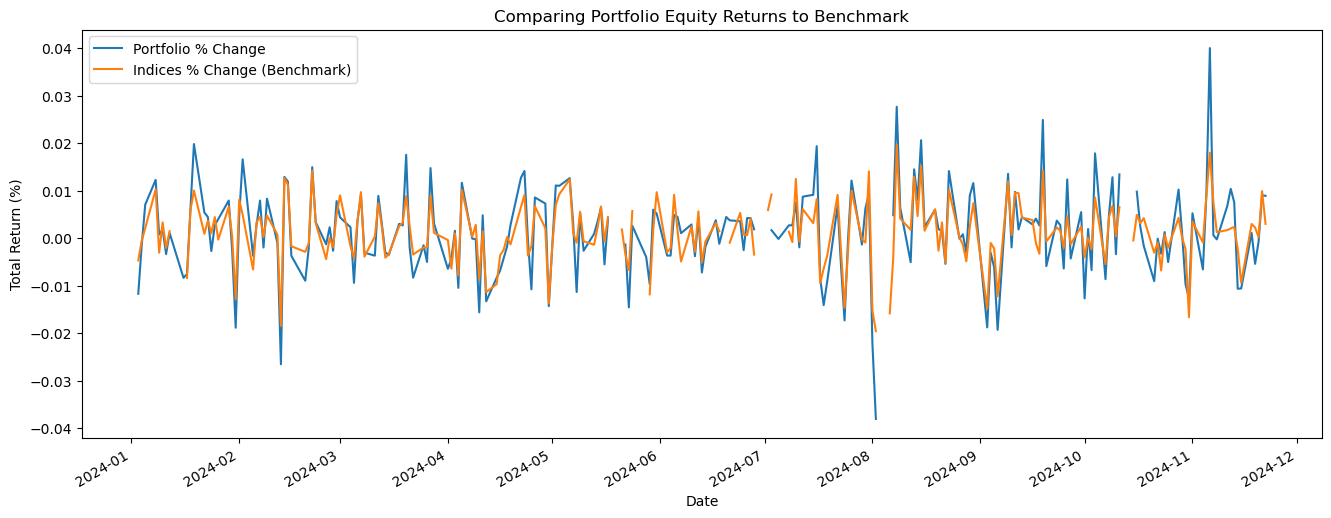

In [ ]:
fig, ax = plt.subplots()
ax.set_title("Comparing Portfolio Equity Returns to Benchmark")
ax.set_xlabel("Date")
ax.set_ylabel("Total Return (%)")


ax.plot(comparison["Portfolio % Change"], label='Portfolio % Change')
ax.plot(comparison["Indices % Change"], label='Indices % Change (Benchmark)')
fig.autofmt_xdate()
ax.legend(loc='best')
plt.gcf().set_size_inches(16, 6)

plt.show()

As we can again see, the returns of our portfolio match the changes in the market indices fairly closely, meaning that we are meeting the market for the most part!

In [ ]:
#export the final stocks and number of shares to csv file
Stocks_Final = Portfolio_Final[['Ticker', 'Shares']]
Stocks_Final.to_csv('Stocks_Group_05.csv')

Thus, here is our final portfolio:

In [ ]:
Portfolio_Final

,Ticker,Weight,Price,Shares,Value,Currency
1,AMZN,9.000000,197.119995,32659.119143,8.999996e+06,USD
2,AAPL,8.633333,229.869995,26865.124161,8.633329e+06,USD
3,CAT,8.266667,397.489990,14876.365842,8.266663e+06,USD
4,C,7.900000,69.839996,80912.476561,7.899996e+06,USD
5,TXN,7.533333,198.000000,27215.392021,7.533329e+06,USD
6,AXP,7.166667,301.299988,17014.166550,7.166663e+06,USD
7,USB,6.800000,52.490002,92666.956977,6.799996e+06,USD
8,SHOP.TO,6.433333,149.479996,43038.062398,6.433329e+06,CAD
9,ACN,6.066667,358.660004,12099.285647,6.066663e+06,USD
10,RY.TO,5.700000,174.710007,32625.469813,5.699996e+06,CAD


## Contribution Declaration

The following team members made a meaningful contribution to this assignment:

James, Emily, Jonathan
